# Libraries

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
# %matplotlib widget    # interactive 3d plots
from sklearn.svm import SVC
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
import data_loader
import model_evaluation
import plotting_utils
import model_training
from sklearn import linear_model
from sklearn import metrics
import copy
from mv_utils import lasso_rank, SVM_eval
# from tqdm import tqdm

c:\Users\Tanya\AppData\Local\Programs\Python\Python310\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


# Feature (MFCC) extraction (Dataset generation)

In [2]:
# run this function if you need to generate a csv data set from scratch
X, y, ID = data_loader.load_dataset(should_generate_dataset=True, 
                                    use_vad=False, 
                                    use_delta_mfcc=False,
                                    use_delta_delta_mfcc=True)

{'ravdess': True, 'ravdess_speech': False, 'ravdess_song': False, 'tess': False}
INFO: n_fft=16384, n_mfcc=34
{'ravdess': True, 'ravdess_speech': False, 'ravdess_song': False, 'tess': False}


0it [00:00, ?it/s]

--- Data loaded. Loading time: 0.0039997100830078125 seconds ---
X.shape =  (0, 0)
y.shape =  (0, 0)
ID.shape =  (0, 0)
data loaded in 0.008996725082397461ms
Empty DataFrame
Columns: []
Index: []
X.shape =  (0, 0)
X.columns =  Index([], dtype='object')


# Loading Dataset

In [3]:
X, y, ID = data_loader.load_dataset(X_path='data/feature_mfcc_delta_delta_nfft_8192.csv', 
                                    y_path='data/y_labels_feature_mfcc_delta_delta_nfft_8192.csv', 
                                    ID_path='data/IDs_feature_mfcc_delta_delta_nfft_8192.csv')

data loaded in 0.3485093116760254ms
          0         1         2         3         4         5         6   
0 -1.259565  0.303245  0.565729  0.740473  1.017606  0.699541  0.550410  \
1 -1.144492  0.379439  0.232604  1.296038  1.095464  0.638897  1.003693   
2 -1.141867  0.700402  0.522715  0.791756  0.681143  0.763471  0.922431   
3 -1.031299  0.594298  0.625426  0.629341  0.822605  1.055398  0.968384   
4 -1.403439  0.651892  0.679810  1.128613  1.029886  0.903193  0.635654   

          7         8         9  ...       350       351       352       353   
0  1.071940 -0.849060 -0.520171  ... -0.357754 -1.052179  0.797295 -0.855256  \
1  0.734590 -0.893826  0.024751  ... -0.405698 -0.460791  0.300362 -0.516186   
2  0.755122 -0.665206 -0.840375  ... -0.155261 -0.880540 -0.051737 -1.095914   
3  0.114642 -0.775878 -0.686340  ...  0.849179 -0.493505  0.503025 -0.386734   
4  0.903227 -0.334770 -0.974429  ... -0.651272 -0.734492  0.129406 -0.600229   

        354       355       356 

## Relabeling and normilizing

In [4]:
y_true = np.zeros((len(y)))
y_true[np.squeeze(y.values=='neutral')] = 1
y_true[y_true==0] = -1

X_data = X.values
X_norm = (X_data - X_data.mean(axis=0)) / X_data.std(axis=0)
y_reg = copy.copy(y_true)

# LASSO ranking

c:\Users\Tanya\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.234e+02, tolerance: 3.584e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\Tanya\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.362e+01, tolerance: 3.584e-02
  model = cd_fast.enet_coordinate_descent(


Text(0, 0.5, 'Coeffs')

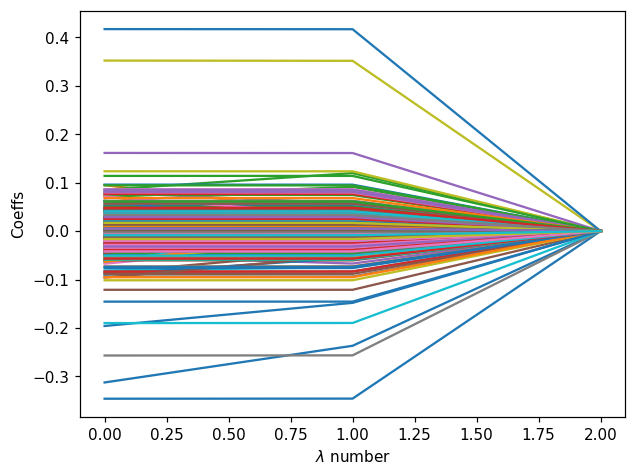

In [5]:

Lasso_model = linear_model.Lasso()
Npt = 3
coeffs = np.zeros((X_norm.shape[1],Npt))
lambda_ = np.logspace(-12.0, 0.5, Npt)
i = 0
for lamb in lambda_:
    Lasso_model = linear_model.Lasso(alpha=lamb, max_iter=20000)
    Lasso_model.fit(X_norm,y_reg)
    coeffs[:,i] = Lasso_model.coef_
    i = i + 1

plt.figure(dpi=110)
plt.plot(coeffs.T)
plt.xlabel('$\lambda$ number')
plt.ylabel('Coeffs')

In [26]:
Rank_lasso = []
for i in range(coeffs.shape[1]-1,-1,-1):
    withdraw_features = np.nonzero(coeffs[:,i])[0];
    something_new = np.setdiff1d(withdraw_features, Rank_lasso)
    if len(something_new):
        for ii in range(len(something_new)):
            Rank_lasso.append(something_new[ii])

In [6]:
# np.save('data/Lasso_Ranking_result.npy', Rank_lasso)    # .npy extension is added if not given
Rank_lasso = np.load('data/Lasso_Ranking_result.npy')

# LOSO accuracy estimation

Iter =  1  AUC = 0.7541
Iter =  2  AUC = 0.7571
Iter =  3  AUC = 0.7649
Iter =  4  AUC = 0.7857
Iter =  7  AUC = 0.7976
Iter =  9  AUC = 0.8151
Iter =  13  AUC = 0.8166
Iter =  14  AUC = 0.8181
Iter =  21  AUC = 0.8237
Iter =  30  AUC = 0.8255
Iter =  38  AUC = 0.8393
Iter =  40  AUC = 0.8449
Iter =  41  AUC = 0.8475
Iter =  42  AUC = 0.8545
auc_best = 0.85453869


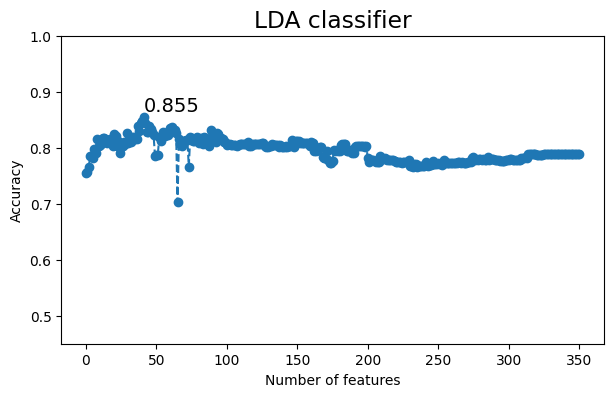

In [7]:
# Rank = lasso_rank(X,y)
# Rank = np.array(Rank)

# subj_IDs = np.squeeze(ID.values)

Rank = Rank_lasso
auc_svm = []
auc_best = 0
ind_best = 0
for k in range(1,len(Rank)+1):
    feature_inds = Rank[:k]
    auc = SVM_eval(X_norm,y_reg, feature_inds, ID)    
    auc_svm.append(auc)
    if (auc>auc_best):
        auc_best = auc
        ind_best = k-1
        print('Iter = ', k, f' AUC = {auc:.4f}' )
    
fig,ax=plt.subplots(figsize=(7,4),dpi=100)
plt.rcParams.update({'font.size': 14})
plt.plot(auc_svm,marker='o', linestyle='dashed')
plt.text(ind_best, auc_best+0.01, f'{auc_best:.3f}')
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.title('LDA classifier')
plt.ylim([0.45, 1.00])

print(f'auc_best = {auc_best:.8f}')

# image_name = 'figures\\ACC_LDA_vowel_a.jpg'
# fig.savefig(image_name, bbox_inches='tight', pad_inches = 0.2)

In [7]:
print(np.max(auc_svm), np.argmax(auc_svm))

0.8545386904761905 41


# Backward step selection

In [10]:
def back_step_selection_loso(X,y,feature_ind, ID):
# BACK_STEP_SELECTION Automatic procedure of feature selection

#basic version
   acc_mu_curr = SVM_eval(X,y,feature_ind, ID)
   some_feature_droped = True
   while (some_feature_droped):
      print('NEW ROUND')
      acc_up = -np.ones_like(feature_ind).astype(np.double)
      for i in tqdm(range(len(feature_ind))):
         cur_inds = np.setdiff1d(feature_ind,feature_ind[i])
         acc_mu = SVM_eval(X,y,cur_inds, ID)                 
         
         if (acc_mu>=acc_mu_curr):            
            acc_up[i] = acc_mu-acc_mu_curr
            print(f'Iter #{i}: {acc_mu:.3f} <-> {acc_mu_curr:.3f}')
      m_val = np.max(acc_up)
      m_ind = np.argmax(acc_up)
      
      if (m_val>=0):
         print(f'Withdraw feature #{m_ind}, added accracy {m_val}')
         feature_ind = np.setdiff1d(feature_ind,feature_ind[m_ind]);
         some_feature_droped = True       
         # new basic version
         acc_mu_curr = SVM_eval(X,y,feature_ind, ID)
      else:
         acc_final = acc_mu_curr
         some_feature_droped = False

   return acc_final, feature_ind

In [11]:
ind_best = np.argmax(auc_svm)
[acc_final,feature_ind] = back_step_selection_loso(X_norm, y_reg, Rank[:ind_best+1],ID)

NEW ROUND


 38%|███▊      | 16/42 [00:35<01:04,  2.50s/it]

Iter #15: 0.856 <-> 0.855


 40%|████      | 17/42 [00:38<01:00,  2.41s/it]

Iter #16: 0.856 <-> 0.855


 43%|████▎     | 18/42 [00:40<00:56,  2.33s/it]

Iter #17: 0.856 <-> 0.855


 50%|█████     | 21/42 [00:47<00:47,  2.24s/it]

Iter #20: 0.856 <-> 0.855


 52%|█████▏    | 22/42 [00:49<00:43,  2.19s/it]

Iter #21: 0.855 <-> 0.855


 64%|██████▍   | 27/42 [01:00<00:32,  2.18s/it]

Iter #26: 0.855 <-> 0.855


 76%|███████▌  | 32/42 [01:10<00:21,  2.17s/it]

Iter #31: 0.855 <-> 0.855


100%|██████████| 42/42 [01:32<00:00,  2.20s/it]


Withdraw feature #16, added accracy 0.0018601190476190688
NEW ROUND


 10%|▉         | 4/41 [00:08<01:16,  2.07s/it]

Iter #3: 0.858 <-> 0.856


 56%|█████▌    | 23/41 [00:49<00:39,  2.18s/it]

Iter #22: 0.858 <-> 0.856


 71%|███████   | 29/41 [01:02<00:26,  2.18s/it]

Iter #28: 0.856 <-> 0.856


 85%|████████▌ | 35/41 [01:15<00:12,  2.17s/it]

Iter #34: 0.856 <-> 0.856


 98%|█████████▊| 40/41 [01:26<00:02,  2.19s/it]

Iter #39: 0.857 <-> 0.856


100%|██████████| 41/41 [01:29<00:00,  2.17s/it]

Iter #40: 0.858 <-> 0.856
Withdraw feature #3, added accracy 0.0014880952380952328


NEW ROUND


  5%|▌         | 2/40 [00:04<01:24,  2.22s/it]

Iter #1: 0.858 <-> 0.858


 18%|█▊        | 7/40 [00:14<01:09,  2.11s/it]

Iter #6: 0.858 <-> 0.858


 57%|█████▊    | 23/40 [00:49<00:33,  1.99s/it]

Iter #22: 0.861 <-> 0.858


100%|██████████| 40/40 [01:25<00:00,  2.15s/it]

Iter #39: 0.858 <-> 0.858
Withdraw feature #22, added accracy 0.0029761904761904656


NEW ROUND


 26%|██▌       | 10/39 [00:18<00:52,  1.83s/it]

Iter #9: 0.861 <-> 0.861


 28%|██▊       | 11/39 [00:20<00:50,  1.82s/it]

Iter #10: 0.861 <-> 0.861


 31%|███       | 12/39 [00:21<00:48,  1.79s/it]

Iter #11: 0.861 <-> 0.861


 97%|█████████▋| 38/39 [01:09<00:01,  1.81s/it]

Iter #37: 0.862 <-> 0.861


100%|██████████| 39/39 [01:11<00:00,  1.83s/it]


Withdraw feature #37, added accracy 0.0007440476190475609
NEW ROUND


 18%|█▊        | 7/38 [00:12<00:55,  1.79s/it]

Iter #6: 0.863 <-> 0.862


 29%|██▉       | 11/38 [00:19<00:46,  1.74s/it]

Iter #10: 0.862 <-> 0.862


100%|██████████| 38/38 [01:09<00:00,  1.82s/it]


Withdraw feature #6, added accracy 0.0014880952380953438
NEW ROUND


 27%|██▋       | 10/37 [00:17<00:47,  1.75s/it]

Iter #9: 0.863 <-> 0.863


 30%|██▉       | 11/37 [00:19<00:45,  1.76s/it]

Iter #10: 0.864 <-> 0.863


 70%|███████   | 26/37 [00:44<00:18,  1.67s/it]

Iter #25: 0.864 <-> 0.863


100%|██████████| 37/37 [01:04<00:00,  1.74s/it]


Withdraw feature #25, added accracy 0.0011160714285713969
NEW ROUND


100%|██████████| 36/36 [01:01<00:00,  1.71s/it]


In [12]:
np.save('data/feature_idx_neutrality.npy', feature_ind)    # .npy extension is added if not given
feature_ind = np.load('data/feature_idx_neutrality.npy')

# 5-fold CV (full feature space)

In [16]:
group_members= data_loader.get_k_fold_group_member()
X_new = pd.DataFrame(X_norm)
X_k_folds, y_k_folds = data_loader.get_custom_k_folds(X_new, y, ID, group_members)

## GridSearch

100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


UAR = 0.407


100%|██████████| 5/5 [00:01<00:00,  3.09it/s]


UAR = 0.425


100%|██████████| 5/5 [00:01<00:00,  3.26it/s]


UAR = 0.447


100%|██████████| 5/5 [00:01<00:00,  3.79it/s]


UAR = 0.457


100%|██████████| 5/5 [00:01<00:00,  4.06it/s]


UAR = 0.464


100%|██████████| 5/5 [00:01<00:00,  4.21it/s]


UAR = 0.470


100%|██████████| 5/5 [00:01<00:00,  4.24it/s]


UAR = 0.453


100%|██████████| 5/5 [00:01<00:00,  4.21it/s]


UAR = 0.440


100%|██████████| 5/5 [00:01<00:00,  4.09it/s]


UAR = 0.426


100%|██████████| 5/5 [00:01<00:00,  4.03it/s]


UAR = 0.426
UAR_best = 0.470, C_best = 0.008


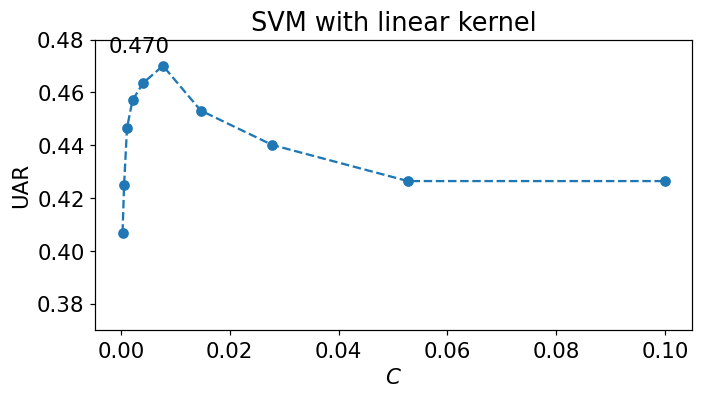

In [24]:
C = np.logspace(-3.5, -1.0, 10, endpoint=True)
UAR_list = []
UAR_best = 0
for val_C in C:
    model = SVC(kernel = 'linear', C=val_C)
    UAR,y_pr,y_tr,y_te = model_training.estimate_model(model, X_k_folds, y_k_folds)
    if UAR_best<UAR:
        UAR_best,y_pred,y_true,y_test = UAR,y_pr,y_tr,y_te
        C_best = val_C
    UAR_list.append(UAR)

# fig,ax=plt.subplots(figsize=(7,3.5))
# plt.rcParams.update({'font.size': 14})
# plt.plot(C,UAR_list, marker='o', linestyle='dashed',)
# plt.ylim([0.37, 0.45])
# plt.xlabel('C')
# plt.ylabel('UAR')

fig,ax=plt.subplots(figsize=(7,3.5), dpi=110) # 
plt.rcParams.update({'font.size': 14})
plt.plot(C,UAR_list, marker='o', linestyle='dashed',)
# plt.semilogx(C,UAR_list, marker='o', linestyle='dashed',)
plt.ylim([0.37, 0.48])
# plt.xlabel('$\log_{10}(C)$')
plt.xlabel('$C$')
plt.ylabel('UAR')
plt.text(C_best-0.010, UAR_best+0.005, f'{UAR_best:.3f}')
plt.title('SVM with linear kernel')
print(f'UAR_best = {UAR_best:.3f}, C_best = {C_best:.3f}')

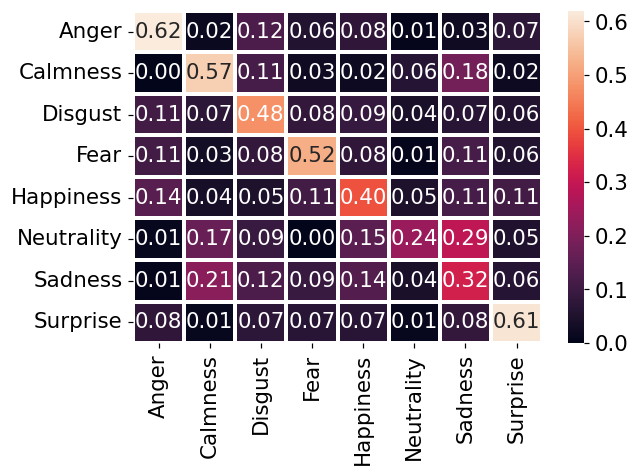

Saving confusion matrix with name:  Doc/figures/confusion_matrix_eng.jpg


In [25]:
# Confusion matrix
plotting_utils.plot_confusion_matrix_eng(y_test, y_true, y_pred)

# 5-fold CV (selected feature space)

In [13]:
group_members= data_loader.get_k_fold_group_member()
X_new = pd.DataFrame(X_norm[:,feature_ind])
X_k_folds, y_k_folds = data_loader.get_custom_k_folds(X_new, y, ID, group_members)

## GridSearch

100%|██████████| 5/5 [00:00<00:00,  8.45it/s]


UAR = 0.269


100%|██████████| 5/5 [00:00<00:00,  8.42it/s]


UAR = 0.269


100%|██████████| 5/5 [00:00<00:00,  8.51it/s]


UAR = 0.273


100%|██████████| 5/5 [00:00<00:00,  7.80it/s]


UAR = 0.288


100%|██████████| 5/5 [00:00<00:00,  8.59it/s]


UAR = 0.302


100%|██████████| 5/5 [00:00<00:00,  8.76it/s]


UAR = 0.324


100%|██████████| 5/5 [00:00<00:00,  8.93it/s]


UAR = 0.336


100%|██████████| 5/5 [00:00<00:00,  8.92it/s]


UAR = 0.348


100%|██████████| 5/5 [00:00<00:00,  8.79it/s]


UAR = 0.357


100%|██████████| 5/5 [00:00<00:00,  8.45it/s]


UAR = 0.365


100%|██████████| 5/5 [00:00<00:00,  9.58it/s]


UAR = 0.376


100%|██████████| 5/5 [00:00<00:00,  9.81it/s]


UAR = 0.384


100%|██████████| 5/5 [00:00<00:00, 10.06it/s]


UAR = 0.383


100%|██████████| 5/5 [00:00<00:00,  9.97it/s]


UAR = 0.384


100%|██████████| 5/5 [00:00<00:00, 10.25it/s]


UAR = 0.392


100%|██████████| 5/5 [00:00<00:00, 10.57it/s]


UAR = 0.390


100%|██████████| 5/5 [00:00<00:00, 10.57it/s]


UAR = 0.397


100%|██████████| 5/5 [00:00<00:00, 10.46it/s]


UAR = 0.400


100%|██████████| 5/5 [00:00<00:00, 10.84it/s]


UAR = 0.410


100%|██████████| 5/5 [00:00<00:00, 11.19it/s]


UAR = 0.410


100%|██████████| 5/5 [00:00<00:00, 10.18it/s]


UAR = 0.409


100%|██████████| 5/5 [00:00<00:00, 11.21it/s]


UAR = 0.417


100%|██████████| 5/5 [00:00<00:00, 11.26it/s]


UAR = 0.419


100%|██████████| 5/5 [00:00<00:00, 11.07it/s]


UAR = 0.418


100%|██████████| 5/5 [00:00<00:00, 11.45it/s]


UAR = 0.424


100%|██████████| 5/5 [00:00<00:00, 10.90it/s]


UAR = 0.418


100%|██████████| 5/5 [00:00<00:00, 11.21it/s]


UAR = 0.416


100%|██████████| 5/5 [00:00<00:00, 11.04it/s]


UAR = 0.424


100%|██████████| 5/5 [00:00<00:00, 10.83it/s]


UAR = 0.417


100%|██████████| 5/5 [00:00<00:00, 10.08it/s]


UAR = 0.422


100%|██████████| 5/5 [00:00<00:00,  8.51it/s]


UAR = 0.414


100%|██████████| 5/5 [00:00<00:00,  8.92it/s]


UAR = 0.405


100%|██████████| 5/5 [00:00<00:00,  8.54it/s]


UAR = 0.402


100%|██████████| 5/5 [00:00<00:00,  7.88it/s]


UAR = 0.400


100%|██████████| 5/5 [00:00<00:00,  7.31it/s]


UAR = 0.402


100%|██████████| 5/5 [00:00<00:00,  6.09it/s]


UAR = 0.396


100%|██████████| 5/5 [00:00<00:00,  5.74it/s]


UAR = 0.400


100%|██████████| 5/5 [00:00<00:00,  5.14it/s]


UAR = 0.404


100%|██████████| 5/5 [00:01<00:00,  4.57it/s]


UAR = 0.398


100%|██████████| 5/5 [00:01<00:00,  3.74it/s]


UAR = 0.402
UAR_best = 0.424, C_best = 0.045


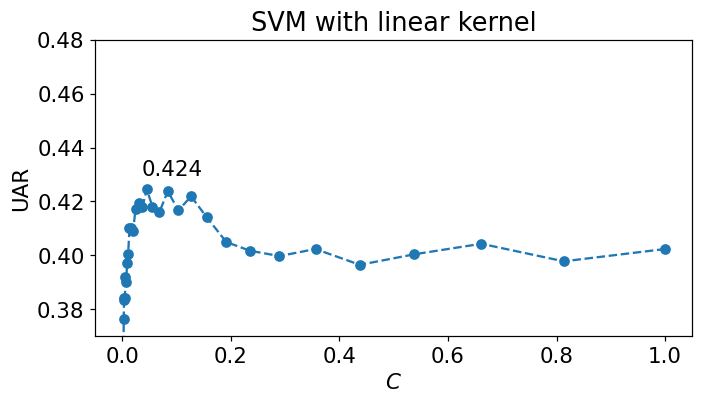

In [14]:
C = np.logspace(-3.5, -0.0, 40, endpoint=True)
UAR_list = []
UAR_best = 0
for val_C in C:
    model = SVC(kernel = 'linear', C=val_C)
    UAR,y_pr,y_tr,y_te = model_training.estimate_model(model, X_k_folds, y_k_folds)
    if UAR_best<UAR:
        UAR_best,y_pred,y_true,y_test = UAR,y_pr,y_tr,y_te
        C_best = val_C
    UAR_list.append(UAR)

fig,ax=plt.subplots(figsize=(7,3.5), dpi=110) 
plt.rcParams.update({'font.size': 14})
plt.plot(C,UAR_list, marker='o', linestyle='dashed',)
# plt.semilogx(C,UAR_list, marker='o', linestyle='dashed',)
plt.ylim([0.37, 0.48])
# plt.xlabel('$\log_{10}(C)$')
plt.xlabel('$C$')
plt.ylabel('UAR')
plt.text(C_best-0.010, UAR_best+0.005, f'{UAR_best:.3f}')
plt.title('SVM with linear kernel')
print(f'UAR_best = {UAR_best:.3f}, C_best = {C_best:.3f}')

## Confusion matrix

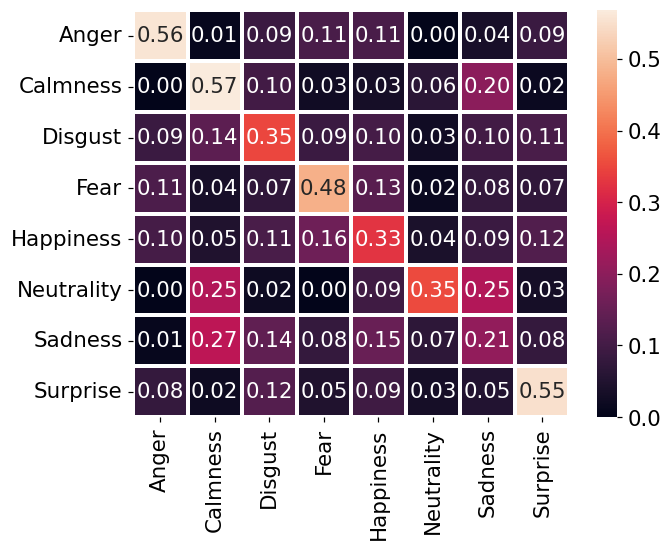

Saving confusion matrix with name:  Doc/figures/confusion_matrix_eng.jpg


In [15]:
plotting_utils.plot_confusion_matrix_eng(y_test, y_true, y_pred)

In [21]:
# Anger + neutrality
# np.save('data/feature_idx_neutrality.npy', feature_ind)    # .npy extension is added if not given
feature_ind_neutr = np.load('data/feature_idx_neutrality.npy')
feature_ind_angry = np.load('data/feature_idx_angry.npy')
results_list = [feature_ind_neutr, feature_ind_angry]
feature_ind = list(set().union(*results_list))

# 5-fold CV (feature angry + neutrality)

100%|██████████| 5/5 [00:00<00:00,  5.20it/s]


UAR = 0.335


100%|██████████| 5/5 [00:00<00:00,  5.45it/s]


UAR = 0.342


100%|██████████| 5/5 [00:00<00:00,  5.56it/s]


UAR = 0.348


100%|██████████| 5/5 [00:00<00:00,  5.43it/s]


UAR = 0.359


100%|██████████| 5/5 [00:00<00:00,  5.86it/s]


UAR = 0.373


100%|██████████| 5/5 [00:00<00:00,  5.93it/s]


UAR = 0.382


100%|██████████| 5/5 [00:00<00:00,  5.98it/s]


UAR = 0.395


100%|██████████| 5/5 [00:00<00:00,  6.05it/s]


UAR = 0.389


100%|██████████| 5/5 [00:00<00:00,  6.33it/s]


UAR = 0.398


100%|██████████| 5/5 [00:00<00:00,  6.45it/s]


UAR = 0.407


100%|██████████| 5/5 [00:00<00:00,  6.55it/s]


UAR = 0.415


100%|██████████| 5/5 [00:00<00:00,  6.63it/s]


UAR = 0.428


100%|██████████| 5/5 [00:00<00:00,  6.89it/s]


UAR = 0.432


100%|██████████| 5/5 [00:00<00:00,  6.99it/s]


UAR = 0.438


100%|██████████| 5/5 [00:00<00:00,  6.52it/s]


UAR = 0.439


100%|██████████| 5/5 [00:00<00:00,  7.13it/s]


UAR = 0.444


100%|██████████| 5/5 [00:00<00:00,  7.05it/s]


UAR = 0.435


100%|██████████| 5/5 [00:00<00:00,  7.43it/s]


UAR = 0.443


100%|██████████| 5/5 [00:00<00:00,  7.45it/s]


UAR = 0.447


100%|██████████| 5/5 [00:00<00:00,  7.49it/s]


UAR = 0.450


100%|██████████| 5/5 [00:00<00:00,  7.50it/s]


UAR = 0.447


100%|██████████| 5/5 [00:00<00:00,  7.39it/s]


UAR = 0.441


100%|██████████| 5/5 [00:00<00:00,  7.37it/s]


UAR = 0.436


100%|██████████| 5/5 [00:00<00:00,  7.30it/s]


UAR = 0.436


100%|██████████| 5/5 [00:00<00:00,  7.08it/s]


UAR = 0.432


100%|██████████| 5/5 [00:00<00:00,  6.42it/s]


UAR = 0.432


100%|██████████| 5/5 [00:00<00:00,  6.56it/s]


UAR = 0.433


100%|██████████| 5/5 [00:00<00:00,  6.40it/s]


UAR = 0.424


100%|██████████| 5/5 [00:00<00:00,  6.14it/s]


UAR = 0.423


100%|██████████| 5/5 [00:00<00:00,  5.84it/s]


UAR = 0.417


100%|██████████| 5/5 [00:00<00:00,  5.62it/s]


UAR = 0.419


100%|██████████| 5/5 [00:00<00:00,  5.47it/s]


UAR = 0.417


100%|██████████| 5/5 [00:00<00:00,  5.19it/s]


UAR = 0.410


100%|██████████| 5/5 [00:00<00:00,  5.03it/s]


UAR = 0.401


100%|██████████| 5/5 [00:01<00:00,  4.87it/s]


UAR = 0.400


100%|██████████| 5/5 [00:01<00:00,  4.53it/s]


UAR = 0.404


100%|██████████| 5/5 [00:01<00:00,  4.36it/s]


UAR = 0.400


100%|██████████| 5/5 [00:01<00:00,  4.43it/s]


UAR = 0.404


100%|██████████| 5/5 [00:01<00:00,  4.41it/s]


UAR = 0.406


100%|██████████| 5/5 [00:01<00:00,  4.25it/s]


UAR = 0.408
UAR_best = 0.450, C_best = 0.016


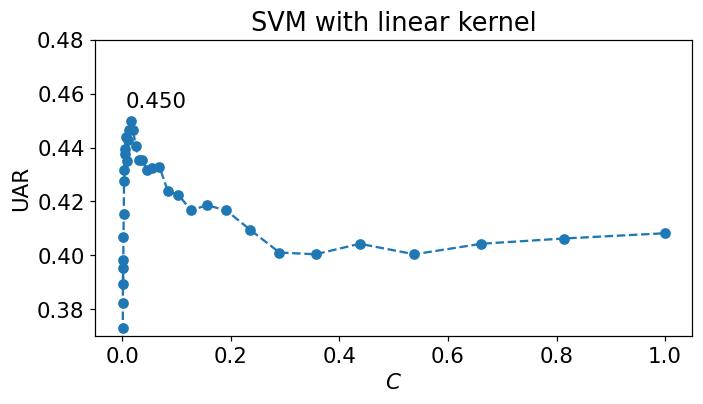

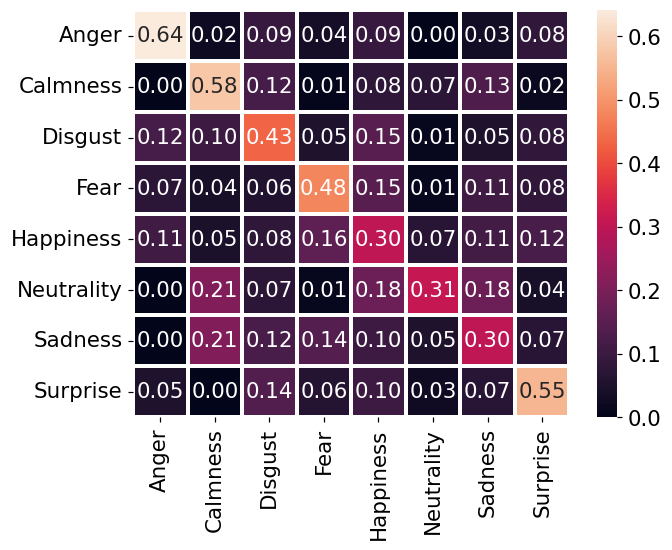

Saving confusion matrix with name:  Doc/figures/confusion_matrix_eng.jpg


In [22]:
group_members= data_loader.get_k_fold_group_member()
X_new = pd.DataFrame(X_norm[:,feature_ind])
X_k_folds, y_k_folds = data_loader.get_custom_k_folds(X_new, y, ID, group_members)

C = np.logspace(-3.5, -0.0, 40, endpoint=True)
UAR_list = []
UAR_best = 0
for val_C in C:
    model = SVC(kernel = 'linear', C=val_C)
    UAR,y_pr,y_tr,y_te = model_training.estimate_model(model, X_k_folds, y_k_folds)
    if UAR_best<UAR:
        UAR_best,y_pred,y_true,y_test = UAR,y_pr,y_tr,y_te
        C_best = val_C
    UAR_list.append(UAR)

fig,ax=plt.subplots(figsize=(7,3.5), dpi=110) 
plt.rcParams.update({'font.size': 14})
plt.plot(C,UAR_list, marker='o', linestyle='dashed',)
# plt.semilogx(C,UAR_list, marker='o', linestyle='dashed',)
plt.ylim([0.37, 0.48])
# plt.xlabel('$\log_{10}(C)$')
plt.xlabel('$C$')
plt.ylabel('UAR')
plt.text(C_best-0.010, UAR_best+0.005, f'{UAR_best:.3f}')
plt.title('SVM with linear kernel')
print(f'UAR_best = {UAR_best:.3f}, C_best = {C_best:.3f}')

plotting_utils.plot_confusion_matrix_eng(y_test, y_true, y_pred)